# Лабораторная работа №2

## Шаг 1 Откройте файл с данными и изучите общую информацию

Описание

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Описание данных

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Для начала импортируем все библиотеки и считываем файл с датасетом. При этом сталкиваемся с проблемой - pandas всё видит как одну колонку. В нашем случае разделители у датасета не стандартная запятая, а табуляция, поэтому чтобы pandas считал всё правильно мы дописываем параметр sep='\t' при чтении файла.

In [4371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('real_estate_data.csv', sep='\t')

In [4372]:
pd.set_option('display.max_columns', None) # Команда, чтобы строки целиком показывались при использовании display

In [4373]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Шаг 2 Предобработка данных

### Обработка пропусков

Можно заметить, что в датасете есть пропуски в столбцах: ceiling_height, living_area, is_apartment, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, floors_total, locality_name. 

Для некоторых пропущенных значений можно предположить логичную замену. Например, если человек не указал число балконов — скорее всего, их нет. Такие пропуски допустимо заменить на 0.

In [4374]:
data['balcony'] = data['balcony'].fillna(0)

Теперь проанализируем информацию о близлежащих объектах. 

Начнём с ponds и для начала посмотрим какие значения появляются у ponds_around3000 и ponds_nearest.

In [4375]:
data['ponds_around3000'].value_counts(dropna=False)

ponds_around3000
0.0    9071
1.0    5717
NaN    5518
2.0    1892
3.0    1501
Name: count, dtype: int64

In [4376]:
data['ponds_nearest'].value_counts(dropna=False)

ponds_nearest
NaN       14589
427.0        70
454.0        41
153.0        40
433.0        39
          ...  
986.0         1
131.0         1
725.0         1
40.0          1
1134.0        1
Name: count, Length: 1097, dtype: int64

Можно заметить, что в ponds_around3000 помимо нулевых значений, есть NaN, но говорить о том, что NaN можно заменить на 0, как в случае с balcony пока рано. В случае с ponds_nearest можно заметить, что есть 14589 строк с пропуском этого значения. Сейчас требуется взглянуть на строки где ponds_around3000 или ponds_nearest равны NaN или ponds_around3000 равен 0.

In [4377]:
data[(data['ponds_around3000'] == 0) | (data['ponds_around3000'].isna()) | (data['ponds_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23690,3,5500000.0,52.00,2018-07-19T00:00:00,2,NaN,5.0,31.00,2,NaN,False,False,6.00,0.0,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,NaN,False,False,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,NaN,False,False,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,NaN,False,False,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Итого мы получили то самое число 14589. Это значит, что ponds_nearest равен NaN только там. где ponds_around3000 равен NaN или 0. Для ponds_nearest логично иметь NaN, которое буквально означает отсутствие расстояния, поэтому его обрабатывать никак не требуется. Если говорить о том, стоит ли заполнять пропуски у ponds_around3000 нулями, то скорее всего это плохая идея. Как минимум можно взглянуть на водоёмы у Всеволожска:

In [4378]:
data.loc[data['locality_name'] == 'Всеволожск']['ponds_around3000'].value_counts(dropna=False)

ponds_around3000
NaN    398
Name: count, dtype: int64

В этом городе они однозначно есть, и шанс что каждое из 400 объявлений были дальше чем на 3 км скорее всего близко к невозможному. Скорее всего в данном случае NaN означает именно отсутствие данных по этим объявлениям (то есть автоматическая картографическая система не смогла рассчитать эти признаки для объявлений), поэтому заполнять их нулями - неправильно.

Также мы поступим и с парками. для начала посмотрим какие значения появляются у parks_around3000 и parks_nearest.

In [4379]:
data['parks_around3000'].value_counts(dropna=False)

parks_around3000
0.0    10106
1.0     5681
NaN     5518
2.0     1747
3.0      647
Name: count, dtype: int64

In [4380]:
data['parks_nearest'].value_counts(dropna=False)

parks_nearest
NaN       15620
441.0        67
173.0        41
392.0        41
456.0        40
          ...  
794.0         1
760.0         1
1167.0        1
4.0           1
2984.0        1
Name: count, Length: 996, dtype: int64

Можно также заметить, что в parks_around3000 помимо нулевых значений, есть NaN. В случае с parks_nearest можно заметить, что есть 15620 строк с пропуском этого значения. Сейчас требуется аналогично взглянуть на строки где parks_around3000 или parks_nearest равны NaN или parks_around3000 равен 0.

In [4381]:
data[(data['parks_around3000'] == 0) | (data['parks_around3000'].isna()) | (data['parks_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.30,7,NaN,False,False,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,NaN,False,False,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,NaN,False,False,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,NaN,False,False,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Можно заметить, что в этот раз мы получили не то же число, что и NaN у parks_nearest. Давайте взглянем на значения parks_nearest для того же условия, потому что если прибавить количество нулей к отстутствующим значениям у parks_nearest мы как раз получим 15624. Следовательно эти 4 строки появляются из-за parks_nearest.

In [4382]:
data[(data['parks_around3000'] == 0) | (data['parks_around3000'].isna()) | (data['parks_nearest'].isna())]['parks_nearest'].value_counts(dropna=False)

parks_nearest
NaN       15620
3190.0        2
3064.0        1
3013.0        1
Name: count, dtype: int64

Можно увидеть те самые 4 значения, которые причем больше 3000. Это не противоречит ничему, поэтому логика обработки пропусков остаётся аналогичной обработке пропусков у водоёмов. Можно даже проверить снова город Всеволожоск на парки, в котором их достаточно много и убедиться, что заполнять пропуски тоже будет ошибкой.

In [4383]:
data.loc[data['locality_name'] == 'Всеволожск']['parks_around3000'].value_counts(dropna=False)

parks_around3000
NaN    398
Name: count, dtype: int64

Из признаков с пропусками, которые заполняются автоматически системой, остались только airports_nearest и cityCenters_nearest.

In [4384]:
data['airports_nearest'].value_counts(dropna=False).sort_index()

airports_nearest
0.0           1
6450.0        2
6914.0        1
6949.0        1
6989.0        6
           ... 
84006.0       1
84665.0       1
84853.0       1
84869.0       1
NaN        5542
Name: count, Length: 8276, dtype: int64

In [4385]:
data['cityCenters_nearest'].value_counts(dropna=False)

cityCenters_nearest
NaN        5519
8460.0       61
20802.0      32
10720.0      30
20444.0      27
           ... 
11965.0       1
6228.0        1
2345.0        1
17882.0       1
16671.0       1
Name: count, Length: 7643, dtype: int64

In [4386]:
data[(data['cityCenters_nearest'].isna()) & (data['airports_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,NaN,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,NaN,False,False,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,NaN,False,False,NaN,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,NaN,False,False,5.50,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,NaN,False,False,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,NaN,False,False,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,NaN,False,False,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Исходя из этого, можно заметить, что большая часть пропусков у этих столбцов связана с одними и теми же строками. Эти строки - 23 процента от общей выборки. Просто так без необходимости пробовать их заполнять не имеет особо смысла - так можно исказить данные.

Теперь перейдём к пропускам столбцов, значения которых устанавливает сам пользователь. Для начала стоит отметить, что в большинстве случае скорее всего - отсутствие данных в этих столбцах значит то, что пользователь либо забыл указать, либо не знает что указывать.

Разберём столбцы living_area и kitchen_area (8% и 10% пропущенных значений соответственно). В целом такое количество пропусков допустимо заполнить выражением (total_area текущей квартиры * средняя доля нужной части квартиры)

In [4387]:
# средние доли
living_ratio = (data['living_area'] / data['total_area']).mean()
kitchen_ratio = (data['kitchen_area'] / data['total_area']).mean()
print(living_ratio, kitchen_ratio)

0.5647655216993234 0.1873547387717406


In [4388]:
# заполнение пропусков
data.loc[data['living_area'].isna(), 'living_area'] = data['total_area'] * living_ratio
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['total_area'] * kitchen_ratio

Далее столбец floors_total. Имеет 86 пропусков. В целом можно удалить эти строки и потери не будут существеные, но я сейчас придерживаюсь стратегии сохранить максимальное количество строк, поэтому просто оставлю их нетронутыми. Заполнить эти пропуски можно, но это будут предположения по типу: если этаж 8, то велика вероятность, что всего их 9, или же писать в количество этаж тот этаж, что и в столбце floor. Я считаю на данный момент особой нужды в этом нет.

In [4389]:
data.loc[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.800000,4,NaN,False,False,12.000000,0.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.750000,1,NaN,False,False,5.264668,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.400000,12,NaN,False,False,10.630000,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.100000,8,NaN,False,False,16.800000,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,22.025855,9,NaN,False,False,7.306835,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.8,NaN,35.862611,3,NaN,False,False,11.897026,0.0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,NaN,NaN,31.700000,20,NaN,False,False,14.400000,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,NaN,NaN,45.380000,6,NaN,False,False,23.420000,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,NaN,NaN,50.400000,18,NaN,False,False,23.600000,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


In [4390]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])

Что касатеся locality_name, то тут всего 49 пропусков, поэтому эти строки целесообразно будет просто удалить. Поскольку мы даже не можем до конца быть уверенными, что это объявления точно из Санкт-Петербурга или из ближайших к нему населенных пунктов.

In [4391]:
data.loc[data['locality_name'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.800000,2,NaN,False,False,8.800000,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,NaN,4.0,42.600000,2,NaN,False,False,18.600000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,NaN,24.0,15.600000,3,NaN,False,False,10.700000,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,NaN,24.0,33.100000,21,NaN,False,False,8.200000,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,NaN,5.0,30.800000,5,NaN,False,False,6.500000,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.620000,7,NaN,False,False,13.380000,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.300000,3,False,False,False,10.400000,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,NaN,7.0,46.875538,6,NaN,False,False,15.550443,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,NaN,7.0,59.100000,5,False,False,False,8.300000,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,NaN,24.0,20.000000,23,NaN,False,False,5.620642,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


In [4392]:
data = data.dropna(subset=['locality_name'])

- Столбец ceiling_height имеет 39% пропусков, заполнение медианными значениями также может привести к искажению данных.
- Столбец is_apartment имеет 88% пропусков, ситуация с этим столбцом ещё хуже, возможно для дальнейшей работы с этими данными его будет смысл удалить, т.к. данных просто мало одтосительно других столбцов. Заполнить его исходя чего-либо невозможно, т.к. ни с чем особо не коррелирует. Поэтому пропуски оставляем.
- Столбец days_exposition означает сколько дней было размещено объявление (от публикации до снятия), поэтому пропуски в нём точно никак не заполнить, данные в нём либо по ошибке в системе не появились, либо объявление у которого days_exposition равен NaN всё ещё активно.

Итого у нас получился датафрейм с такими строками:

In [4393]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest      18

### Приведение данных к нужным типам

Для начала давайте взглянем ещё раз на таблицу

In [4394]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [4395]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,NaN,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.600000,1,NaN,False,False,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.300000,4,NaN,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,89.797718,9,NaN,False,False,29.789403,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,NaN,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


- last_price - можно поменять на int (хотя сомнительно конретно для этой колонки, ибо если потом добавлять какие-то данные тут могут появится копейки и получиться странно, но может в рамках этой работы мне не стоит это учитывать)
- first_day_exposition - в идеале какой-то формат даты наверно нужно для этого столбца, потому что object я вообще хз че за тип данных
- floors_total - можно поменять на nullable int (ну тут точно не может быть float, но при этом у меня null тут есть)
- is_apartment - можно поменять на nullable bool(ситуация аналогичная)
- balcony - можно поменять на int
- locality_name - можно поменять на str (тут тоже object хз к чему)
- parks_around3000 - можно поменять на nullable int (ну тут точно не может быть float, но при этом у меня null тут есть)
- ponds_around3000 - можно поменять на nullable int (ну тут точно не может быть float, но при этом у меня null тут есть)
- days_exposition - можно поменять на nullable int (ну тут точно не может быть float, но при этом у меня null тут есть)

In [4396]:
data = data.astype({
    'last_price': 'int',
    'floors_total': 'Int64',
    'is_apartment': 'boolean',
    'balcony': 'int',
    'locality_name': 'str',
    'parks_around3000': 'Int64',
    'ponds_around3000': 'Int64'
})

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['days_exposition'] = data['days_exposition'].round().astype('Int64')

## Шаг 3 Посчитайте и добавьте в таблицу

По заданию нужно добавить:
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей.


In [4397]:
data = data.assign(
    price_m2 = data['last_price'] / data['total_area'],
    living_ratio = data['living_area'] / data['total_area'],
    kitchen_ratio = data['kitchen_area'] / data['total_area']
)


data = data.assign(
    weekday = data['first_day_exposition'].dt.day_of_week,
    month = data['first_day_exposition'].dt.month,
    year = data['first_day_exposition'].dt.year
)

In [4398]:
conditions = [
    data['floor'] == 1,
    data['floor'] == data['floors_total'],
    (data['floor'] != 1) & (data['floor'] != data['floors_total'])
]

choices = ['first', 'last', 'other']

data['floor_category'] = np.select(conditions, choices, default='unknown')

Итого можно взглянуть на столбцы, которые у нас получились:

In [4399]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,living_ratio,kitchen_ratio,weekday,month,year,floor_category
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,<NA>,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370.370370,0.472222,0.231481,3,3,2019,other
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.600000,1,<NA>,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079,0.460396,0.272277,1,12,2018,first
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.300000,4,<NA>,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,0.612500,0.148214,3,8,2015,other
3,0,64900000,159.0,2015-07-24,3,NaN,14,89.797718,9,<NA>,False,False,29.789403,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,0.564766,0.187355,4,7,2015,other
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,<NA>,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,0.320000,0.410000,1,6,2018,other


## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции

#### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра. ✅



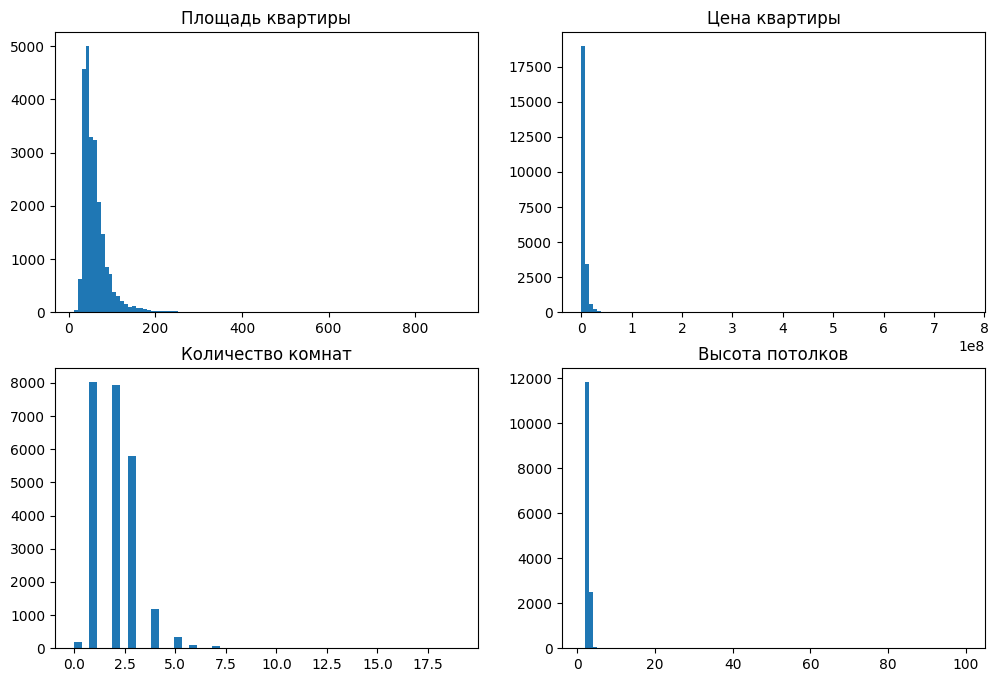

In [4400]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.hist(data['total_area'], bins=100)
plt.title('Площадь квартиры')

plt.subplot(2,2,2)
plt.hist(data['last_price'], bins=100)
plt.title('Цена квартиры')

plt.subplot(2,2,3)
plt.hist(data['rooms'], bins=50)
plt.title('Количество комнат')

plt.subplot(2,2,4)
plt.hist(data['ceiling_height'], bins=100)
plt.title('Высота потолков')

plt.show()

Можно заметить, что каждого из этих признаков есть аномальные/очень редкие значения в боьшую сторону, как например у столбца площадь квартиры, какое-то из значений достигает значения 800, хотя основная масса вхождений находится в пределах 250.

#### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго? ✅

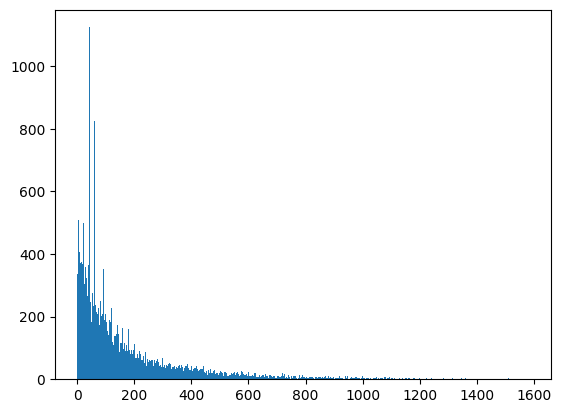

In [4401]:
plt.hist(data['days_exposition'], bins=500)
plt.show()

In [4402]:
data['days_exposition'].describe()

count       20470.0
mean       180.7532
std      219.777916
min             1.0
25%            45.0
50%            95.0
75%           231.0
max          1580.0
Name: days_exposition, dtype: Float64

- Среднее время продажи квартиры составляет около 181 дня, медианное — 95 дней.
- Обычно продажа занимает от 45 до 231 дня (интервал между 25-м и 75-м перцентилями).
- Если квартира продаётся быстрее чем за 45 дней, это можно считать очень быстрой продажей, а если дольше чем за 231 день — необычно долгой.

#### Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили. ✅

Судя по гистограмме, основная масса квартир сосредоточена до 250 м², и после этого значения встречаются крайне редко, что характерно для элитного сегмента и выбивается из общей выборки.

In [4403]:
data.loc[data['total_area'] > 250].shape[0]

112

Как можно заметить, это примерно 0.5% значений всей выборки, что крайне мало, поэтому удаление этих редких значений ни к чему плохому не приведёт. Гистрограмма стала более симметричной. После удаления выбросов распределение стало более равномерным и наглядно отражает реальные значения.

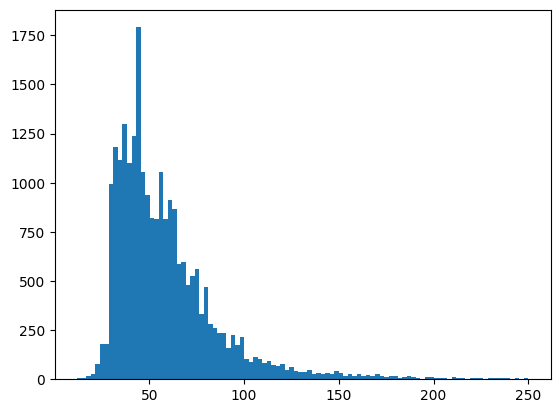

In [4404]:
data = data[data['total_area'] <= 250]

plt.hist(data['total_area'], bins=100)
plt.show()

Далее идёт столбец ceiling_height. Анализируя гистограмму, которую мы сделали до этого, можно увидеть, что справа также имеется огромная пустота, которая возможно возникла, из-за аномального максимального значения 100 (скорее всего причина появления - ошибка ввода) в выборке. Оно в любом случае будет удалено, а пока перейдём к статистике из интернета, где сказано, что квартиры премиум класса могут иметь потолки до 4 метров в высоту, поэтому мы проверим, сколько у нас значений именно выше этого показателя. Кроме того, потолки ниже 2.5 метров в целом запрещены для жилых помещений, поэтому их количество также стоит проанализировать.

In [4405]:
data.loc[(data['ceiling_height'] > 4) | (data['ceiling_height'] < 2.5)].shape[0]

139

Итого у нас получилось 0.6% от общей выборки, что некритично будет удалить. После удаления выбросов распределение стало более равномерным и наглядно отражает реальные значения.

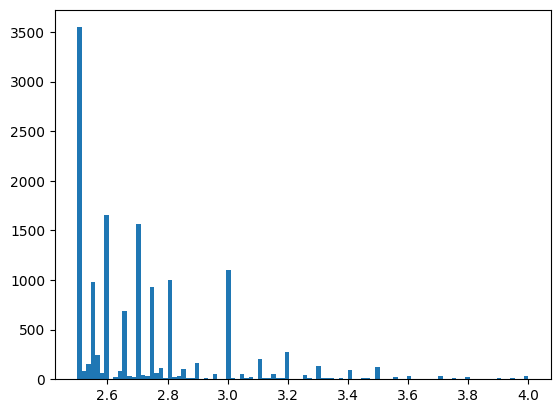

In [4406]:
data = data.loc[~((data['ceiling_height'] > 4) | (data['ceiling_height'] < 2.5))]
plt.hist(data['ceiling_height'], bins=100)
plt.show()

Далее разберём столбец rooms. 
- Если взглянуть на гистограмму можно сделать вывод, что квартир с количеством комнат больше 7 крайне мало. Проверив это с помощью loc, было получено число 15, которое ничтожно мало в рамках нашей выборки (0,06%), поэтому удаляем строки с этими значениями, т.к. слишком редкие. 
- Кроме того, на гистограмме можно заметить какое-то количество квартир, с числом комнат 0. Проанализировав это более тщательно, было выяснено, что все эти квартиры относятся либо к студиям, либо к квартирам с открытой планировкой. 
    - В случае студии всё понятно, мы просто заменяем 0 на 1, так как это справедливо, и в России студии считаются за однокомнатные квартиры. 
    - С квартирами, где open_plan == True всё немного сложнее, но тем не менее, в общей выборке мы можем заметить, что есть значения комнат у них отличные от 0, хоть их и немного. Это говорит о том, что, скорее всего, тут некоторые люди указывали в значение 0, т.к. в открытой планировке нет разделяющих стен и, как следствие, нет комнат, а другие, возможно, указывали примерное количество комнат, которое можно получить на выходе. Тем не менее я считаю, что 0 в данном случае некорректным значением, поэтому значение 0 заменено на NaN, так как оно не отражает реальное количество комнат и скорее указывает на неопределённую планировку.

In [4407]:
data.loc[data['rooms'] > 7].shape[0]

15

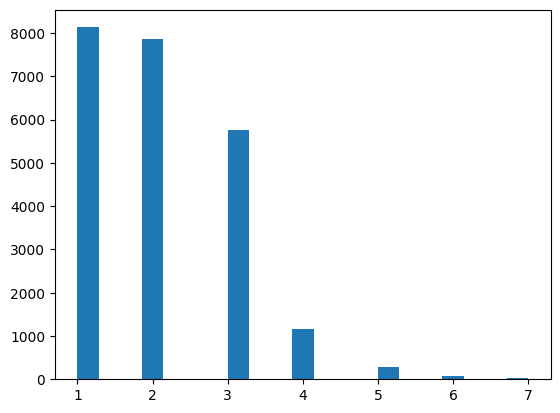

In [4408]:
data = data[data['rooms'] <= 7]
data.loc[(data['rooms'] == 0) & (data['studio'] == True), 'rooms'] = 1
data.loc[(data['rooms'] == 0) & (data['open_plan'] == True), 'rooms'] = np.nan

plt.hist(data['rooms'], bins=21)
plt.show()

Далее обработаем столбец floors_total. Поскольку до этого мы до этого не строили диаграмму значений этого столбца, строим её сейчас. На ней можно увидеть, что этажность домов примерно после 28-30 перестаёт появляться. По итогу, если быть точным, есть всего 31 дом, у которых этажей больше чем 28, что около 0.1% от общей выборки, поэтому мы можем удалить их, по причине чрезмерной редкости. Гистограмма стала более читаемой.

Text(0.5, 1.0, 'Количество этажей в доме')

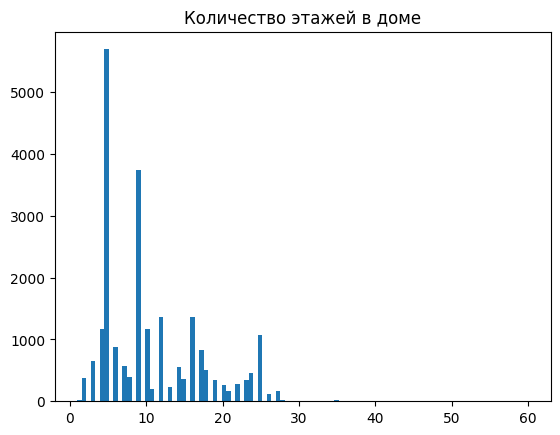

In [4409]:
plt.hist(data['floors_total'], bins=100)
plt.title('Количество этажей в доме')

In [4410]:
data.loc[data['floors_total'] > 28].shape[0]

31

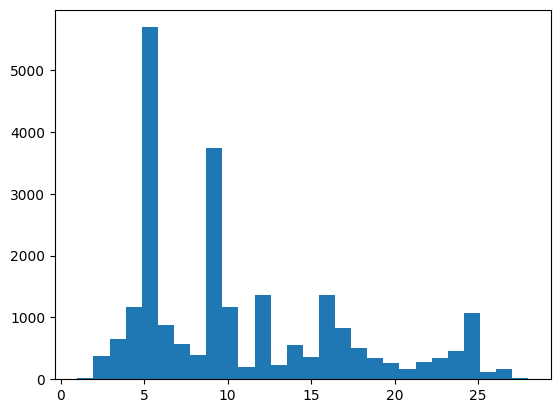

In [4411]:
data = data[data['floors_total'] <= 28]

plt.hist(data['floors_total'], bins=28)
plt.show()

Последнее, что мы обработаем - столбец last_price. Взглянув на изначальную гистограмму, можно заметить, что основная масса элементов выборки находится до 50 млн. рублей. Если быть точным квартир со стоимостью больше 40 млн. всего 114 (0,5% от всей выборки), поэтому аналично предыдущим обработкам, мы удалим строки с этими значениями, т.к. они слишком редки, и в итоге получим более читаемую гистограмму.

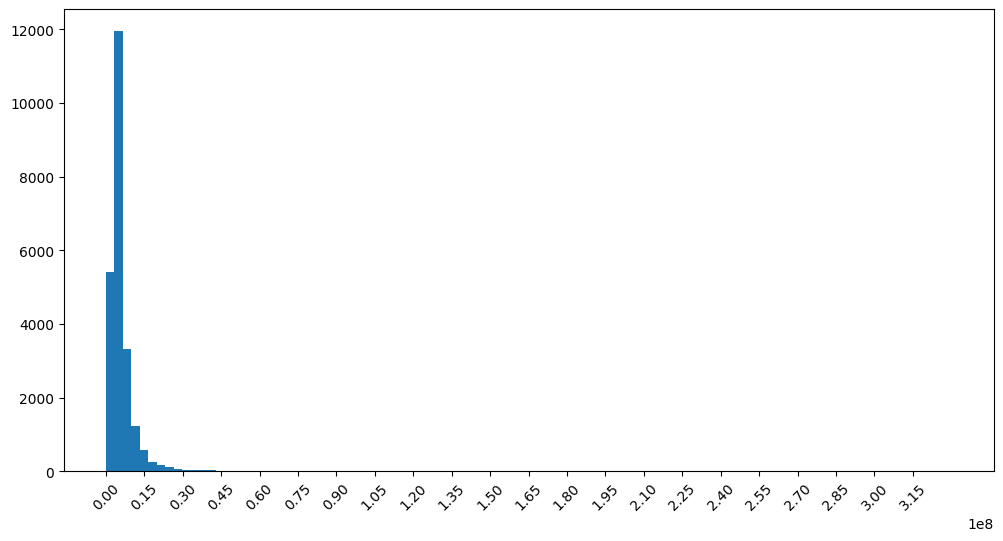

In [4412]:
plt.figure(figsize=(12,6))
plt.hist(data['last_price'], bins=100)
plt.xticks(range(0, data['last_price'].max(), 15_000_000), rotation=45)
plt.show()

In [4413]:
data.loc[data['last_price'] > 40_000_000].shape[0]

114

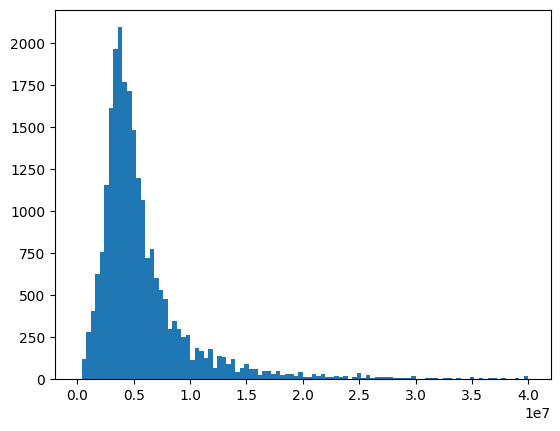

In [4414]:
data = data[data['last_price'] <= 40_000_000]

plt.hist(data['last_price'], bins=100)
plt.show()

#### Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года. ✅

In [4415]:
data.corr(numeric_only=True)['last_price'].sort_values()

cityCenters_nearest   -0.340005
ponds_nearest         -0.110068
kitchen_ratio         -0.102436
studio                -0.050347
year                  -0.038164
airports_nearest      -0.036432
open_plan             -0.032848
weekday               -0.010638
month                  0.003984
living_ratio           0.009284
parks_nearest          0.021066
balcony                0.036680
floors_total           0.057521
is_apartment           0.065834
floor                  0.067304
days_exposition        0.126535
total_images           0.154775
parks_around3000       0.193922
ponds_around3000       0.199184
rooms                  0.497837
ceiling_height         0.514541
kitchen_area           0.617587
living_area            0.683610
price_m2               0.693210
total_area             0.783040
last_price             1.000000
Name: last_price, dtype: float64

Можно заметить, что больше всего с итоговой ценой коррелируют такие числовые признаки как cityCenters_nearest, total_area (как следиствие living_area, kitchen_area), ceiling_height, rooms.

Далее по заданию требуется изучить, зависит ли цена от площади, числа комнат, удалённости от центра.

In [4416]:
data['int_area'] = data['total_area'].astype('int')

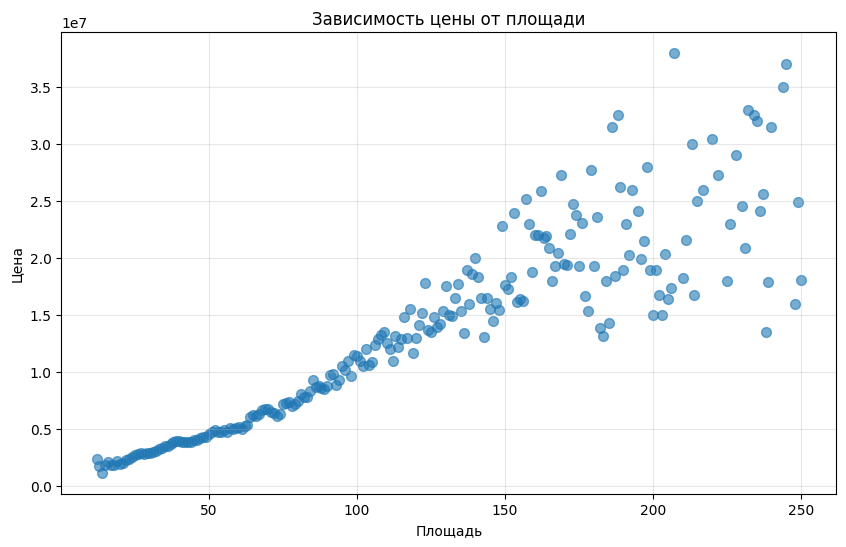

In [4417]:
# Для выявления корреляции между двумя числовыми параметрами
plt.figure(figsize=(10, 6))
plt.scatter(data.groupby('int_area')['last_price'].median().index, data.groupby('int_area')['last_price'].median().values, alpha=0.6, s=50)
plt.title('Зависимость цены от площади')
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.grid(True, alpha=0.3)
plt.show()

На графике можно увидеть хорошо выраженный рост (в начале хорошо его заметно, под конец график немного расплывается, скорее всего из-за маленького количества данных по премиальному сегменту) цены на квартиру, который происходит по мере возрастания площади квартиры.

Далее рассмотрим зависимость цены от количества комнат также на примере графика. На нём четко виден рост цены с увеличением числа комнат. Довольно логичная зависимость, как и в случае площади.

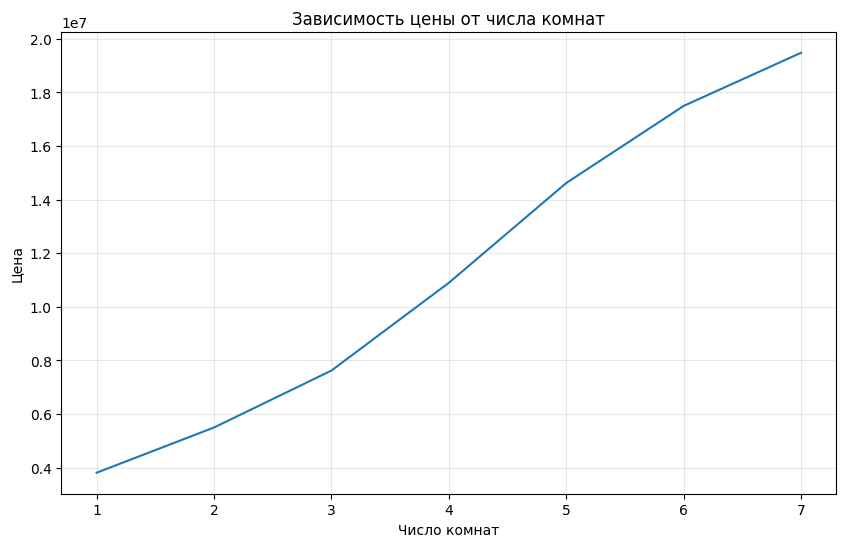

In [4418]:
# Для выявления корреляции между двумя числовыми параметрами
plt.figure(figsize=(10, 6))
plt.plot(data.groupby('rooms')['last_price'].mean().index, data.groupby('rooms')['last_price'].mean().values)
plt.title('Зависимость цены от числа комнат')
plt.xlabel('Число комнат')
plt.ylabel('Цена')
plt.grid(True, alpha=0.3)
plt.show()

Что касается удалённости от центра, на графике также видно что медианная цена падает с ростом этой самой удаленности (за исключением двух пиков примерно на 43 и 55 километрах, которые скорее всего получились из-за того, что на эти значения выпали только большие квартиры).

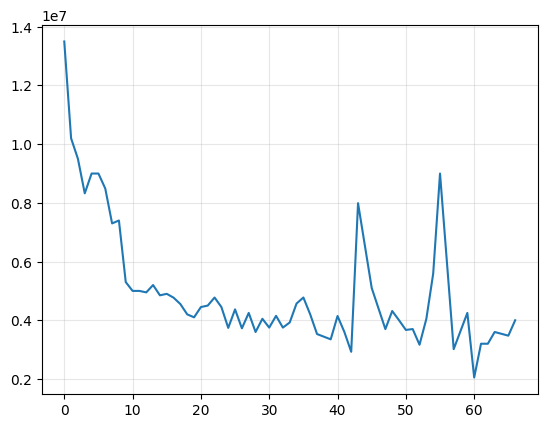

In [4419]:
data['cityCenters_nearest_km']  = (data['cityCenters_nearest'] / 1000).round(0).astype('Int64')
plt.plot(data.groupby('cityCenters_nearest_km')['last_price'].median())
plt.grid(True, alpha=0.3)
plt.show()

Далее у нас по заданию изучение зависимости цены от того, на каком этаже расположена квартира: первом, последнем или другом.
Я решил сравнить это с двух ракусов: с помощью графика построенного по медианам, а также с помощью boxplot. В целом по обоим графикам можно понять то, что исходя из нашей выборки квартиры на 1 этаже, как правило, дешевле остальных. Далее по росту цены идут квартиры на последнем этаже, и дороже всего стоят квартиры "между первым и последним".

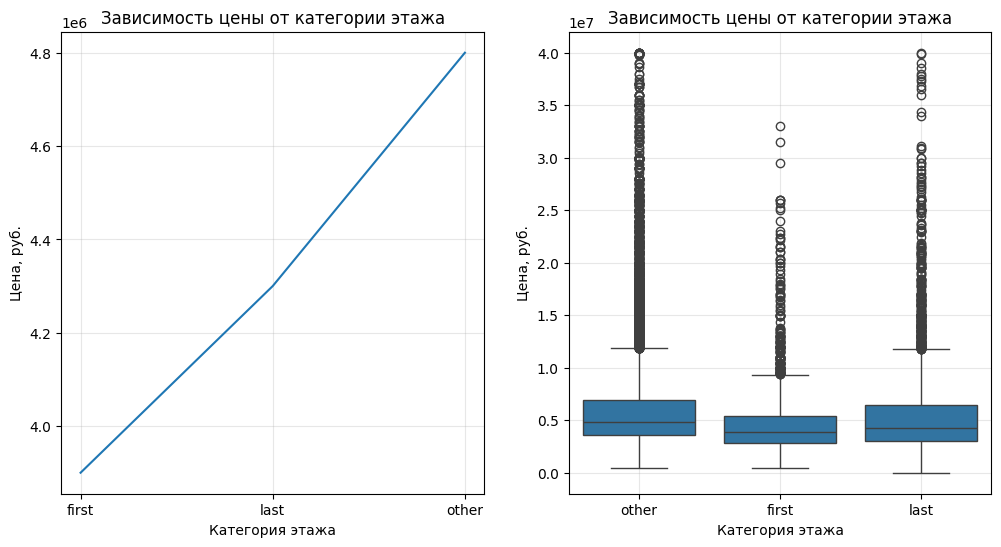

In [4420]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Зависимость цены от категории этажа')
plt.xlabel('Категория этажа')
plt.ylabel('Цена, руб.')
plt.plot(data.groupby('floor_category')['last_price'].median())
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
sns.boxplot(data=data, x='floor_category', y='last_price')
plt.title('Зависимость цены от категории этажа')
plt.xlabel('Категория этажа')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)
plt.show()

Также от нас требуется изучить зависимость от даты размещения: дня недели, месяца и года.

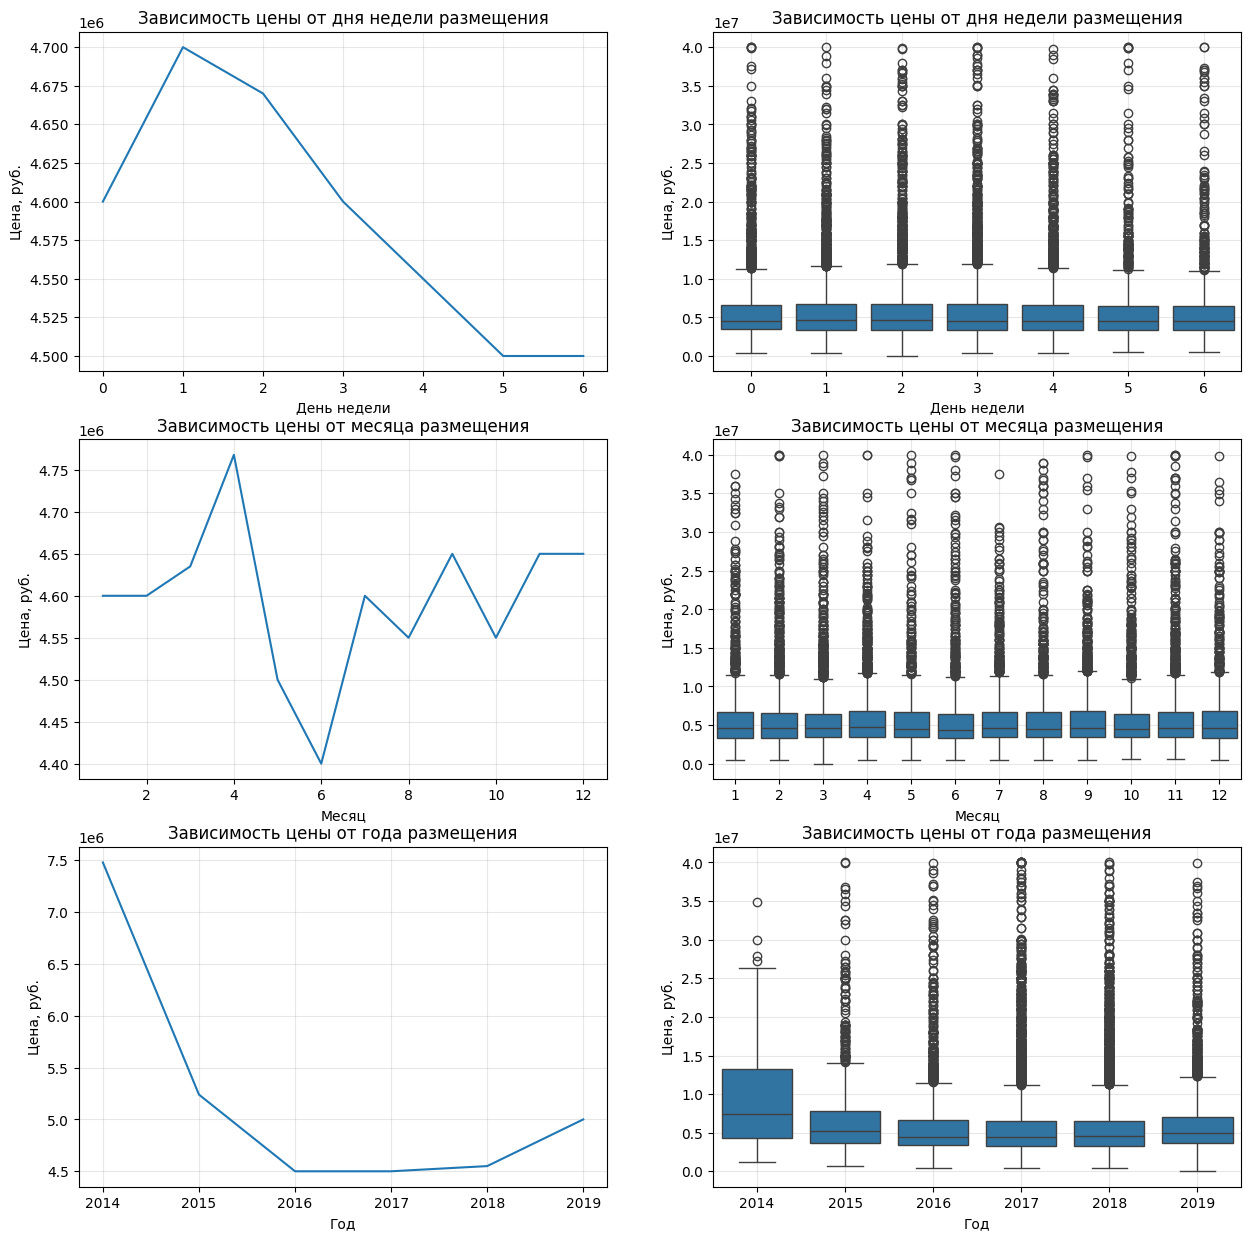

In [4421]:
# День недели
plt.figure(figsize=(15, 15))
plt.subplot(3,2,1)
plt.title('Зависимость цены от дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.plot(data.groupby('weekday')['last_price'].median())
plt.grid(True, alpha=0.3)


plt.subplot(3,2,2)
sns.boxplot(data=data, x='weekday', y='last_price')
plt.title('Зависимость цены от дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)

# Месяц
plt.subplot(3,2,3)
plt.title('Зависимость цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб.')
plt.plot(data.groupby('month')['last_price'].median())
plt.grid(True, alpha=0.3)


plt.subplot(3,2,4)
sns.boxplot(data=data, x='month', y='last_price')
plt.title('Зависимость цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)


# Год
plt.subplot(3,2,5)
plt.title('Зависимость цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Цена, руб.')
plt.plot(data.groupby('year')['last_price'].median())
plt.grid(True, alpha=0.3)


plt.subplot(3,2,6)
sns.boxplot(data=data, x='year', y='last_price')
plt.title('Зависимость цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)

plt.show()

- На графиках представлены зависимости цены квартиры от дня недели, месяца и года размещения объявления.
- Использование двух типов визуализаций (линейных графиков медианных значений и boxplot'ов) позволяет оценить не только средние тенденции, но и разброс цен.
- Из медианных графиков может показаться, что в некоторые дни недели или месяцы цены заметно отличаются, однако boxplot показывает, что диапазоны цен схожи. 
- Это говорит о том, что день недели и месяц размещения объявления практически не влияют на стоимость квартиры: колебания отражают скорее периоды повышенной или сниженной активности продавцов, а не реальное изменение цен.

- Что касается зависимости от года размещения, наблюдается выраженная динамика: в 2014–2015 годах цены были выше, затем к 2016 году произошло значительное снижение, после чего начался постепенный рост, усилившийся к 2018–2019 годам. Таким образом, можно говорить о ценовых тенденциях на рынке, связанных с экономической ситуацией.

#### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце locality_name.✅

In [4422]:
# Выясняем топ-10 населённых пунктов по числу объявлений
target_cities = data.groupby('locality_name')['last_price'].count().sort_values().tail(10).index
# Создаём новый датафрейм с этими населёнными пунктами
data_top10 = data[data['locality_name'].isin(target_cities)]
# Вычисляем среднюю цену за м2 в этих населённых пунктах
data_top10.groupby('locality_name')['price_m2'].mean().sort_values()

locality_name
Выборг                58190.128008
Всеволожск            68670.459639
Гатчина               68757.678644
Колпино               75352.475583
посёлок Шушары        78677.364217
посёлок Мурино        85725.241381
посёлок Парголово     90190.956116
деревня Кудрово       92473.547576
Пушкин               103084.708244
Санкт-Петербург      111671.862832
Name: price_m2, dtype: float64

Итого мы имеем 10 городов с наибольшим числом объявлений, а также посчитанные для них средние цены за квадратный метр жилья. Поскольку квадратный метр идеально отражает стоимость жилья, можно сделать вывод о том, что городами с самой высокой стоимостью жилья являются: Санкт-Петербург, Пушкин, деревня Кудрово; с самой низкой стоимостью: Выборг, Всеволожск, Гатчина.

#### Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (locality_name). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется, — это и будет центральная зона.✅

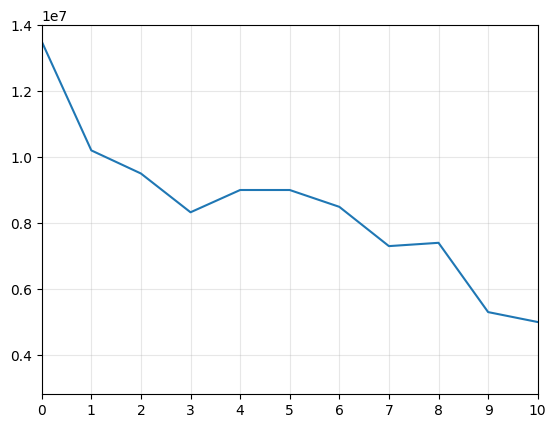

In [4423]:
data_spb = data[(data['locality_name'] == 'Санкт-Петербург')].copy()
data_spb['cityCenters_nearest_km']  = (data_spb['cityCenters_nearest'] / 1000).round(0).astype('Int64')
plt.plot(data_spb.groupby('cityCenters_nearest_km')['last_price'].median())
plt.xlim((0,10)) # Ограничение X до 10 км, чтобы анализировать только фактический Санкт-Петербург
plt.grid(True, alpha=0.3)
plt.xticks(range(0,11))

plt.show()

Исходя из графика можно заметить, что примерно на удаленности в 3 км от центра после довольно плавного графика идёт более интенсивный рост, что говорит о том, что именно эту зону можно считать границей центральной зоны города. Также можно увидеть, что на расстоянии 1 км рост ещё более интенсивный, что можно назвать "абсолютным" центром, с самыми дорогими квартирами по медиане.

#### Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?

In [4424]:
data_spb_center = data[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'] <= 3000.0)]

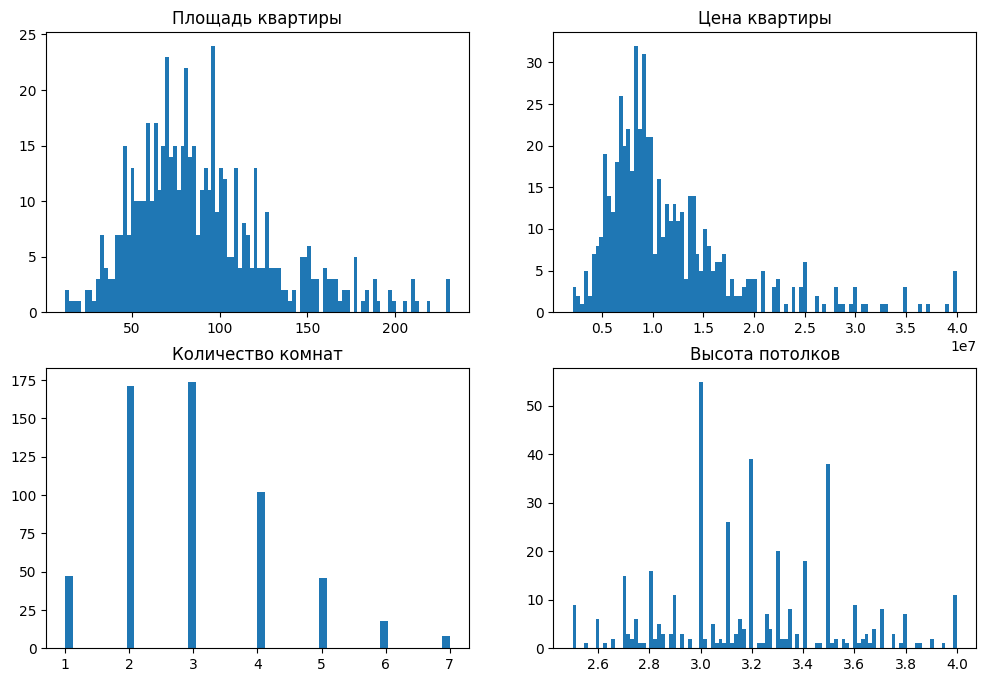

In [4426]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.hist(data_spb_center['total_area'], bins=100)
plt.title('Площадь квартиры')

plt.subplot(2,2,2)
plt.hist(data_spb_center['last_price'], bins=100)
plt.title('Цена квартиры')

plt.subplot(2,2,3)
plt.hist(data_spb_center['rooms'], bins=50)
plt.title('Количество комнат')

plt.subplot(2,2,4)
plt.hist(data_spb_center['ceiling_height'], bins=100)
plt.title('Высота потолков')

plt.show()

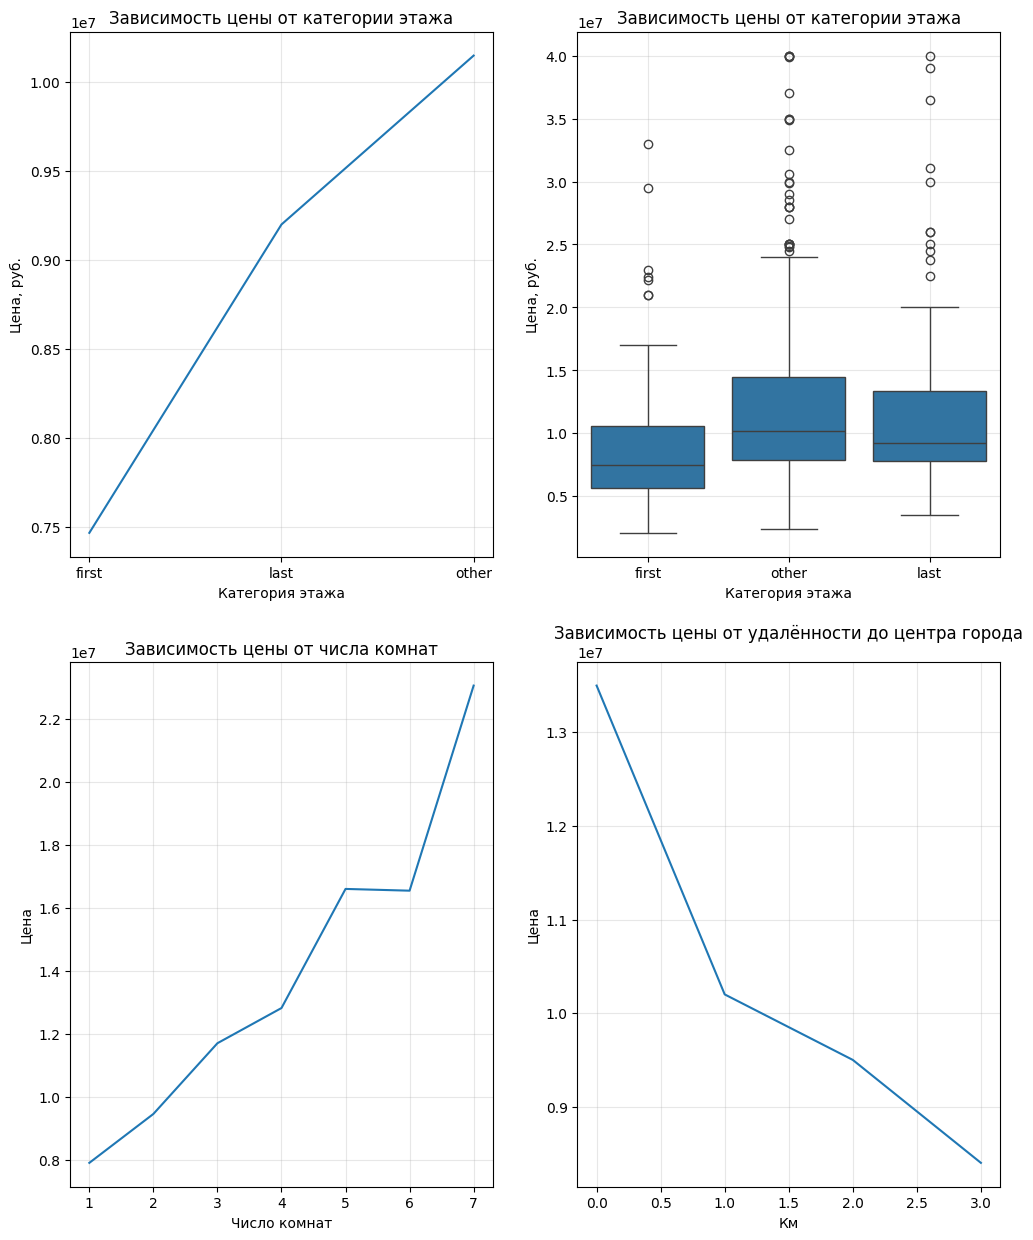

In [4434]:
plt.figure(figsize=(12, 15))
plt.subplot(2,2,1)
plt.title('Зависимость цены от категории этажа')
plt.xlabel('Категория этажа')
plt.ylabel('Цена, руб.')
plt.plot(data_spb_center.groupby('floor_category')['last_price'].median())
plt.grid(True, alpha=0.3)

plt.subplot(2,2,2)
sns.boxplot(data=data_spb_center, x='floor_category', y='last_price')
plt.title('Зависимость цены от категории этажа')
plt.xlabel('Категория этажа')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)


plt.subplot(2,2,3)
plt.plot(data_spb_center.groupby('rooms')['last_price'].mean().index, data_spb_center.groupby('rooms')['last_price'].mean().values)
plt.title('Зависимость цены от числа комнат')
plt.xlabel('Число комнат')
plt.ylabel('Цена')
plt.grid(True, alpha=0.3)

plt.subplot(2,2,4)
plt.plot(data_spb_center.groupby('cityCenters_nearest_km')['last_price'].median())
plt.title('Зависимость цены от удалённости до центра города')
plt.xlabel('Км')
plt.ylabel('Цена')
plt.grid(True, alpha=0.3)

plt.show()

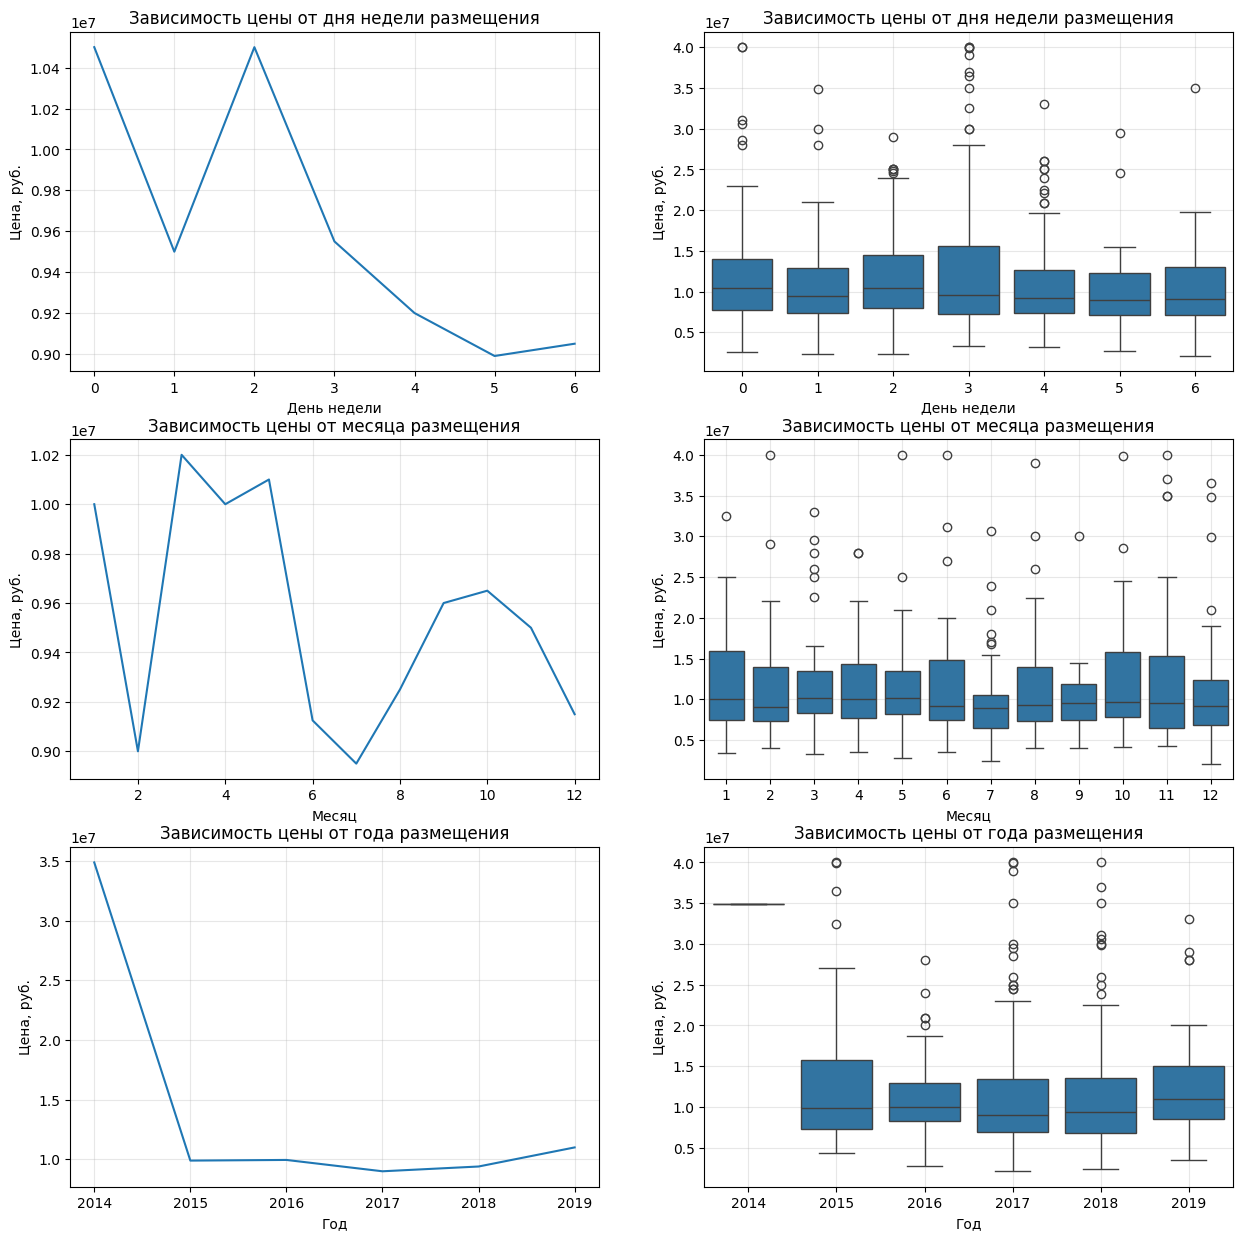

In [4425]:
# День недели
plt.figure(figsize=(15, 15))
plt.subplot(3,2,1)
plt.title('Зависимость цены от дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.plot(data_spb_center.groupby('weekday')['last_price'].median())
plt.grid(True, alpha=0.3)


plt.subplot(3,2,2)
sns.boxplot(data=data_spb_center, x='weekday', y='last_price')
plt.title('Зависимость цены от дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)

# Месяц
plt.subplot(3,2,3)
plt.title('Зависимость цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб.')
plt.plot(data_spb_center.groupby('month')['last_price'].median())
plt.grid(True, alpha=0.3)


plt.subplot(3,2,4)
sns.boxplot(data=data_spb_center, x='month', y='last_price')
plt.title('Зависимость цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)


# Год
plt.subplot(3,2,5)
plt.title('Зависимость цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Цена, руб.')
plt.plot(data_spb_center.groupby('year')['last_price'].median())
plt.grid(True, alpha=0.3)


plt.subplot(3,2,6)
sns.boxplot(data=data_spb_center, x='year', y='last_price')
plt.title('Зависимость цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Цена, руб.')
plt.grid(True, alpha=0.3)

plt.show()

Говоря о параметрах (площадь, цена, число комнат, высота потолков) стоит сказать, что основная масса квартир по площади стала больше, цена в среднем увеличилась, в количестве комнат произошёл сдвиг в сторону 2 и 3 комнатных квартир. Высота потолков сместилась в среднем с 2.5 до 3 метров и выше.
С точки зрения факторов, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления), то они примерно схожи с тем. что было в общей выборке, и влияют на цену также.

## Шаг 5. Напишите общий вывод

В ходе лабораторной работы были практически изучены вопросы обработки пропусков, аномалий и редких значений в данных. Также в качестве инструмента для анализа данных была применена библиотка matplotlib, которая сильно упрощает анализ большого количества данных, особенно выраженного в числах.